# Correlating SAT Scores and NYC Demographics

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. In this notebook I will investigate  correlations between SAT scores and New York City demographics such as race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the [demographics](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) for each high school.

Unfortunately, combining both of the data sets won't give me all of the demographic information I want to use. I'll need to supplement the data with other sources to do my full analysis.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these data sets are interrelated. I'll need to combine them into a single data set before I can find correlations.

## Load Data
### Read in the data
I'll read each file into a pandas dataframe, and then store all of the dataframes in a dictionary. This will give me a convenient way to store them, and a quick way to reference them later on.

In [38]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the survey data
I'll read in the survey data, combine them, capitalize the DBN column to match the other datasets, and keep only the columns I'm interested in.

In [12]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Clean and Combine Data
### Add DBN columns
Each school in New York City has a unique code called a DBN, or district borough number. Ill create a DBN column in the datasets that are missing the column but contain the information to build one. 

In [13]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric
A single column that totals up the SAT scores for the different sections of the exam will make it much easier to correlate scores with demographic factors because I'll be working with a single number, rather than three different ones.

Before we can generate this column, I'll need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_results` data set from the object (string) data type to a numeric data type.

Next, I'll want to parse the latitude and longitude coordinates for each school. This will enable me to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` data set. I can extract the data with a regular expression.

In [14]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets
While the main data set I want to analyze, `sat_results`, has unique DBN values for every high school in New York City, other data sets aren't as clean. A single row in the `sat_results` data set may match multiple rows in the `class_size` data set, for example. This situation will create problems, because I don't know which of the multiple entries in the `class_size` data set I should combine with the single matching entry in sat_results. I'll need to condense these data sets so that each value in the DBN column is unique.

In [15]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric
High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a `1` to `5` scale; `3` or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, I'll need to convert the AP exam scores in the `ap_2010` data set to numeric values first

In [16]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

Both the `ap_2010` and the `graduation` data sets have many missing DBN values, so I'll use a left join when I merge the `sat_results` data set with them.

Because the remaining files contain information that's more valuable to my analysis and also have fewer missing DBN values, I'll use the inner join type.

In [17]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping
Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help me accomplish this.

The school district is just the first two characters of the `DBN`. I can apply a function over the `DBN` column of `combined` that pulls out the first two letters.

In [18]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analyze Data
### Find correlations
Correlations indicate how closely related two columns are. I'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

An r value falls between -1 and 1. The value tells us whether two columns are positively correlated, not correlated, or negatively correlated. The closer to 1 the r value is, the stronger the positive correlation between the two columns. The closer to -1 the r value is, the stronger the negative correlation. The closer to 0, the weaker the correlation.

In [20]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations =  correlations.sort_values()
print(correlations)

frl_percent         -0.722225
sped_percent        -0.448170
ell_percent         -0.398750
hispanic_per        -0.396985
black_per           -0.284139
                       ...   
grade_span_max            NaN
expgrade_span_max         NaN
priority08                NaN
priority09                NaN
priority10                NaN
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations 

In [21]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

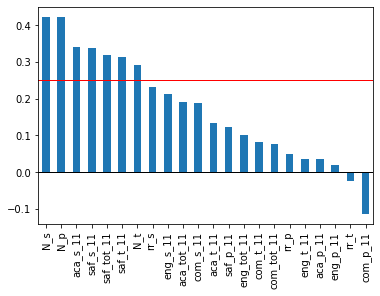

In [69]:
%matplotlib inline
correlations[survey_fields].sort_values(ascending = False).plot.bar()
plt.axhline(y=.25,linewidth=1, color='r')
plt.axhline(y=0,linewidth=1, color='k')

In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. An r value isn't perfect, and doesn't indicate that there's a correlation -- just the possibility of one. To really assess whether or not a correlation exists, we need to look at the data using a scatterplot to see its "shape."

From the correlations chart above, I see none of these variables have a very strong correlation with sat score. But there are some interesting correlations. `N_s` and `N_p` have the strongest correlation at about 0.42 Since these columns are correlated with total_enrollment, it makes sense that they would be high. 

How students and teachers perceived safety `(saf_t_11` and `saf_s_11`) showed the next highest correlation with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation with sat_score is how the student perceives academic standards,`aca_s_11`. Even more interesting is the lack of correlation with `aca_t_11`, how teachers perceive academic standards, and `aca_p_11`, how parents perceive academic standards.

### Exploring Safety
I'll first look at safety data, and use a scatterplot to see the shape of the correlation.

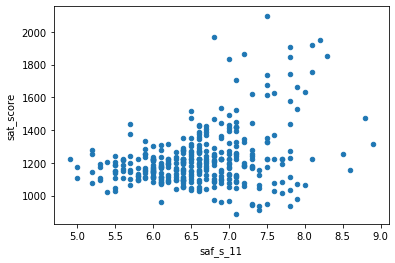

In [62]:
combined.plot.scatter('saf_s_11', 'sat_score')

From the plot aboove, it appears there might be a  weak correlation between SAT scores and safety. It looks like there are a few schools with extremely high SAT scores and higher safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Plotting Safety
I'll see if we see any regional or spatial trends, by plotting the data on a map aggregated to the school district level.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


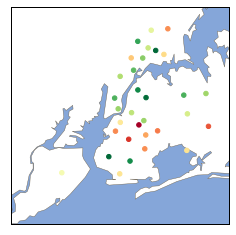

In [33]:
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)


from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

lon = districts['lon'].tolist()
lat = districts['lat'].tolist()
    
m.scatter(lon, lat, s=20, zorder=2, latlon=True, 
          c=districts['saf_s_11'], cmap='RdYlGn')

Manhattan and parts of Queens and the Bronx tend to have higher safety scores(more green), whereas Brooklyn has low safety scores(more red).

### Exploring Race

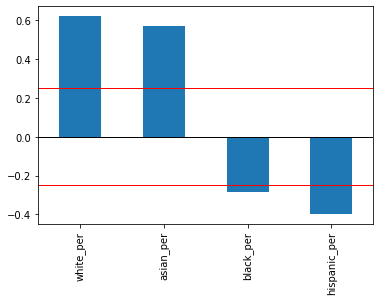

In [68]:
racecols = ['white_per','asian_per',
            'black_per','hispanic_per']
correlations[racecols].plot.bar()
plt.axhline(y=.25,linewidth=1, color='r')
plt.axhline(y=0,linewidth=1, color='k')
plt.axhline(y=-.25,linewidth=1, color='r')

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students may correlate negatively with sat score.

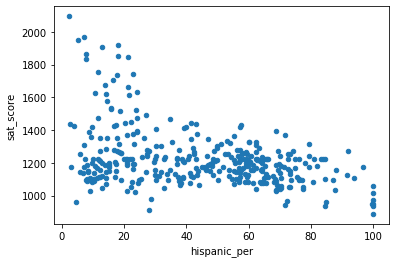

In [61]:
combined.plot.scatter('hispanic_per', 'sat_score')

Schools with 100% hispanic students do not have a SAT Scores greater than 1200. However, Schools with less than 10% hispanic students SAT scores range from under 1000 to over 2000.

In [63]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above have more than 95% hispanic students and appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which could explain the lower SAT scores.

In [64]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Exploring Gender

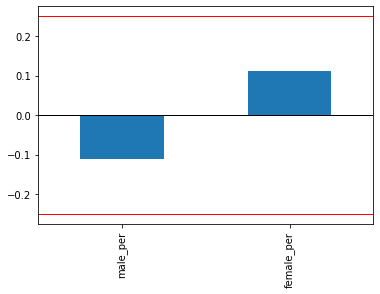

In [67]:
gender_cols=['male_per','female_per']
correlations[gender_cols].plot.bar()
plt.axhline(y=.25,linewidth=1, color='r')
plt.axhline(y=0,linewidth=1, color='k')
plt.axhline(y=-.25,linewidth=1, color='r')

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong, and neither meets the threshold for interesting correlations (+/- .25, shown in red).

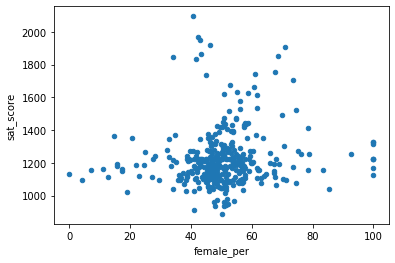

In [70]:
combined.plot.scatter('female_per','sat_score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [71]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

## Exploring AP Tests

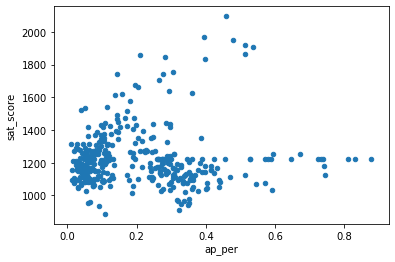

In [77]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter('ap_per','sat_score')


It looks like there could be relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

## Conclusions

I've done quite a bit of investigation into relationships between demographics and SAT scores in this notebook. I've determined that safety and race/ethnicity show some correlation to SAT Score. Gender shows a very week correlation. There's still quite a bit of analysis left to do. Here are some potential next steps:

- Determining whether there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
- If I combine this information with a dataset containing property values, I could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.

However, I will be moving on to other projects to continue learning and practicing. 